In [1]:
import kagglehub

# Download the selected version
path = kagglehub.dataset_download("elmadafri/the-wildfire-dataset/versions/1")

print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/the-wildfire-dataset


In [4]:
import shutil

# Copy the dataset to a writable directory
writable_path = "/kaggle/working/my_dataset30"
shutil.copytree(path, writable_path)


'/kaggle/working/my_dataset30'

In [5]:
!rm /kaggle/working/my_dataset30/the_wildfire_dataset/the_wildfire_dataset/val/fire/Both_smoke_and_fire/desktop.ini

In [6]:
shutil.rmtree('/kaggle/working/my_dataset2')

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class AdvancedCNN(nn.Module):
    def __init__(self):
        super(AdvancedCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier_binary = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )
        self.classifier_multi = nn.Sequential(
            nn.Linear(512 * 7 * 7, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 5)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        binary_output = self.classifier_binary(x)
        multi_class_output = self.classifier_multi(x)
        return binary_output, multi_class_output

model = AdvancedCNN()


In [8]:
criterion_binary = nn.BCELoss()
criterion_multi_class = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [9]:
from torchvision import transforms

# Define data transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [10]:
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomFireDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.binary_labels = []
        self.multi_class_labels = []

        # Define mappings for binary and multi-class labels
        binary_label_mapping = {'fire': 1, 'nofire': 0}
        multi_class_mapping = {
            'fire': {'Both_smoke_and_fire': 0, 'Smoke_from_fires': 1},
            'nofire': {'Fire_confounding_elements': 2, 'Forested_areas_without_confounding_elements': 3, 'Smoke_confounding_elements': 4}
        }

        # Traverse the root directory and collect image paths and labels
        for binary_label_name in os.listdir(root_dir):
            binary_label_path = os.path.join(root_dir, binary_label_name)
            if os.path.isdir(binary_label_path):
                # Assign binary label
                binary_label = binary_label_mapping[binary_label_name]

                # Traverse subclasses
                for subclass_name in os.listdir(binary_label_path):
                    subclass_path = os.path.join(binary_label_path, subclass_name)
                    if os.path.isdir(subclass_path):
                        # Assign multi-class label
                        multi_class_label = multi_class_mapping[binary_label_name][subclass_name]

                        # Collect all images in the subclass directory
                        for img_name in os.listdir(subclass_path):
                            img_path = os.path.join(subclass_path, img_name)
                            if os.path.isfile(img_path):
                                self.image_paths.append(img_path)
                                self.binary_labels.append(binary_label)
                                self.multi_class_labels.append(multi_class_label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        binary_label = self.binary_labels[idx]
        multi_class_label = self.multi_class_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, (torch.tensor(binary_label, dtype=torch.float), torch.tensor(multi_class_label, dtype=torch.long))


In [11]:
# Initialize datasets
train_dataset = CustomFireDataset(
    root_dir="/kaggle/working/my_dataset30/the_wildfire_dataset/the_wildfire_dataset/train",
    transform=train_transforms
)

val_dataset = CustomFireDataset(
    root_dir="/kaggle/working/my_dataset30/the_wildfire_dataset/the_wildfire_dataset/val",
    transform=val_transforms
)


In [12]:
from torch.utils.data import DataLoader

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Initialize lists to store metrics 
epochs = [] 
train_binary_accuracies = [] 
train_multiclass_accuracies = [] 
val_binary_accuracies = [] 
val_multiclass_accuracies = [] 
losses = []


num_epochs = 30  # Start with more epochs for thorough training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train_binary = 0
    total_train_binary = 0
    correct_train_multi_class = 0
    total_train_multi_class = 0

    for images, (binary_labels, multi_class_labels) in train_loader:
        images = images.to(device)
        binary_labels = binary_labels.to(device).float()
        multi_class_labels = multi_class_labels.to(device).long()

        optimizer.zero_grad()
        binary_output, multi_class_output = model(images)
        
        loss_binary = criterion_binary(binary_output.squeeze(), binary_labels)
        loss_multi_class = criterion_multi_class(multi_class_output, multi_class_labels)
        loss = loss_binary + loss_multi_class
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted_binary = (binary_output.squeeze() > 0.5).int()
        correct_train_binary += (predicted_binary == binary_labels.int()).sum().item()
        total_train_binary += binary_labels.size(0)
        
        _, predicted_multi_class = torch.max(multi_class_output, 1)
        correct_train_multi_class += (predicted_multi_class == multi_class_labels).sum().item()
        total_train_multi_class += multi_class_labels.size(0)
        
    avg_loss = running_loss / len(train_loader)
    train_binary_accuracy = 100 * correct_train_binary / total_train_binary
    train_multi_class_accuracy = 100 * correct_train_multi_class / total_train_multi_class

    # Logging training metrics 
    epochs.append(epoch + 1) 
    train_binary_accuracies.append(train_binary_accuracy) 
    train_multiclass_accuracies.append(train_multi_class_accuracy) 
    losses.append(avg_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Binary Accuracy: {train_binary_accuracy:.2f}%, Multi-Class Accuracy: {train_multi_class_accuracy:.2f}%")

    # Validation Loop
    model.eval()
    correct_val_binary = 0
    total_val_binary = 0
    correct_val_multi_class = 0
    total_val_multi_class = 0
    with torch.no_grad():
        for images, (binary_labels, multi_class_labels) in val_loader:
            images = images.to(device)
            binary_labels = binary_labels.to(device).float()
            multi_class_labels = multi_class_labels.to(device).long()

            binary_output, multi_class_output = model(images)
            
            predicted_binary = (binary_output.squeeze() > 0.5).int()
            correct_val_binary += (predicted_binary == binary_labels.int()).sum().item()
            total_val_binary += binary_labels.size(0)
            
            _, predicted_multi_class = torch.max(multi_class_output, 1)
            correct_val_multi_class += (predicted_multi_class == multi_class_labels).sum().item()
            total_val_multi_class += multi_class_labels.size(0)

    val_binary_accuracy = 100 * correct_val_binary / total_val_binary
    val_multi_class_accuracy = 100 * correct_val_multi_class / total_val_multi_class
    
    # Logging validation metrics 
    val_binary_accuracies.append(val_binary_accuracy) 
    val_multiclass_accuracies.append(val_multi_class_accuracy)
    print(f"Validation Binary Accuracy: {val_binary_accuracy:.2f}%, Multi-Class Accuracy: {val_multi_class_accuracy:.2f}%")


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1/30, Loss: 1.6787, Binary Accuracy: 74.56%, Multi-Class Accuracy: 52.89%
Validation Binary Accuracy: 73.63%, Multi-Class Accuracy: 54.23%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 2/30, Loss: 1.4878, Binary Accuracy: 80.02%, Multi-Class Accuracy: 57.76%
Validation Binary Accuracy: 79.60%, Multi-Class Accuracy: 63.93%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 3/30, Loss: 1.3922, Binary Accuracy: 82.09%, Multi-Class Accuracy: 61.31%
Validation Binary Accuracy: 73.63%, Multi-Class Accuracy: 59.95%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 4/30, Loss: 1.4016, Binary Accuracy: 81.98%, Multi-Class Accuracy: 60.52%
Validation Binary Accuracy: 79.35%, Multi-Class Accuracy: 65.17%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 5/30, Loss: 1.2727, Binary Accuracy: 84.68%, Multi-Class Accuracy: 63.65%
Validation Binary Accuracy: 82.84%, Multi-Class Accuracy: 66.42%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 6/30, Loss: 1.2230, Binary Accuracy: 85.32%, Multi-Class Accuracy: 65.45%
Validation Binary Accuracy: 83.83%, Multi-Class Accuracy: 65.42%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 7/30, Loss: 1.1991, Binary Accuracy: 84.84%, Multi-Class Accuracy: 65.66%
Validation Binary Accuracy: 83.58%, Multi-Class Accuracy: 68.66%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 8/30, Loss: 1.1206, Binary Accuracy: 85.85%, Multi-Class Accuracy: 68.26%
Validation Binary Accuracy: 86.07%, Multi-Class Accuracy: 65.42%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 9/30, Loss: 1.1130, Binary Accuracy: 86.22%, Multi-Class Accuracy: 68.26%
Validation Binary Accuracy: 80.35%, Multi-Class Accuracy: 68.66%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 10/30, Loss: 1.0216, Binary Accuracy: 88.18%, Multi-Class Accuracy: 71.01%
Validation Binary Accuracy: 86.07%, Multi-Class Accuracy: 70.90%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 11/30, Loss: 1.0023, Binary Accuracy: 88.39%, Multi-Class Accuracy: 70.91%
Validation Binary Accuracy: 86.57%, Multi-Class Accuracy: 73.13%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 12/30, Loss: 0.9847, Binary Accuracy: 89.08%, Multi-Class Accuracy: 71.33%
Validation Binary Accuracy: 84.08%, Multi-Class Accuracy: 68.41%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 13/30, Loss: 0.9065, Binary Accuracy: 89.83%, Multi-Class Accuracy: 73.87%
Validation Binary Accuracy: 83.83%, Multi-Class Accuracy: 68.66%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 14/30, Loss: 0.8875, Binary Accuracy: 90.04%, Multi-Class Accuracy: 74.99%
Validation Binary Accuracy: 85.82%, Multi-Class Accuracy: 69.65%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 15/30, Loss: 0.8795, Binary Accuracy: 89.67%, Multi-Class Accuracy: 73.93%
Validation Binary Accuracy: 86.07%, Multi-Class Accuracy: 71.39%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 16/30, Loss: 0.8350, Binary Accuracy: 90.89%, Multi-Class Accuracy: 76.21%
Validation Binary Accuracy: 84.58%, Multi-Class Accuracy: 71.89%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 17/30, Loss: 0.8282, Binary Accuracy: 89.88%, Multi-Class Accuracy: 76.63%
Validation Binary Accuracy: 87.06%, Multi-Class Accuracy: 72.39%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 18/30, Loss: 0.7599, Binary Accuracy: 92.32%, Multi-Class Accuracy: 78.33%
Validation Binary Accuracy: 85.57%, Multi-Class Accuracy: 68.16%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 19/30, Loss: 0.7493, Binary Accuracy: 92.32%, Multi-Class Accuracy: 77.80%
Validation Binary Accuracy: 85.57%, Multi-Class Accuracy: 69.15%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 20/30, Loss: 0.6773, Binary Accuracy: 93.32%, Multi-Class Accuracy: 79.97%
Validation Binary Accuracy: 85.07%, Multi-Class Accuracy: 71.89%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 21/30, Loss: 0.6522, Binary Accuracy: 92.95%, Multi-Class Accuracy: 80.71%
Validation Binary Accuracy: 87.56%, Multi-Class Accuracy: 72.14%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 22/30, Loss: 0.6898, Binary Accuracy: 92.32%, Multi-Class Accuracy: 80.98%
Validation Binary Accuracy: 87.81%, Multi-Class Accuracy: 71.14%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 23/30, Loss: 0.5595, Binary Accuracy: 93.64%, Multi-Class Accuracy: 83.20%
Validation Binary Accuracy: 83.83%, Multi-Class Accuracy: 67.41%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 24/30, Loss: 0.5723, Binary Accuracy: 94.86%, Multi-Class Accuracy: 83.36%
Validation Binary Accuracy: 85.32%, Multi-Class Accuracy: 67.91%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 25/30, Loss: 0.5469, Binary Accuracy: 94.33%, Multi-Class Accuracy: 84.95%
Validation Binary Accuracy: 86.57%, Multi-Class Accuracy: 67.66%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 26/30, Loss: 0.5222, Binary Accuracy: 94.97%, Multi-Class Accuracy: 85.00%
Validation Binary Accuracy: 86.07%, Multi-Class Accuracy: 71.64%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 27/30, Loss: 0.4947, Binary Accuracy: 95.02%, Multi-Class Accuracy: 85.85%
Validation Binary Accuracy: 88.31%, Multi-Class Accuracy: 68.66%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 28/30, Loss: 0.4898, Binary Accuracy: 95.50%, Multi-Class Accuracy: 85.90%
Validation Binary Accuracy: 86.32%, Multi-Class Accuracy: 69.40%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 29/30, Loss: 0.4468, Binary Accuracy: 95.76%, Multi-Class Accuracy: 87.12%
Validation Binary Accuracy: 85.82%, Multi-Class Accuracy: 72.14%


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 30/30, Loss: 0.4019, Binary Accuracy: 97.30%, Multi-Class Accuracy: 87.71%
Validation Binary Accuracy: 86.32%, Multi-Class Accuracy: 69.40%


In [15]:
# Save the model's state dictionary
torch.save(model.state_dict(), "CustomCNN_fire_multi_classifier.pth")
print("Model saved successfully!")

Model saved successfully!


In [17]:
import pandas as pd
# Save metrics to a DataFrame and CSV file 
metrics_data = pd.DataFrame(
    { "Epochs": epochs, 
     "Train Binary Accuracy": train_binary_accuracies, 
     "Train Multi-Class Accuracy": train_multiclass_accuracies, 
     "Validation Binary Accuracy": val_binary_accuracies, 
     "Validation Multi-Class Accuracy": val_multiclass_accuracies, 
     "Loss": losses 
    }) 
metrics_data.to_csv("training_metrics.csv", index=False) 
print("Metrics saved successfully!")

Metrics saved successfully!


In [18]:
# Assuming test data is structured similarly
test_dataset = CustomFireDataset(
    root_dir="/kaggle/working/my_dataset30/the_wildfire_dataset/the_wildfire_dataset/test",
    transform=val_transforms
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


In [19]:
def evaluate_test_accuracy(model, test_loader):
    model.eval()
    correct_test_binary = 0
    total_test_binary = 0
    correct_test_multi_class = 0
    total_test_multi_class = 0

    with torch.no_grad():
        for images, (binary_labels, multi_class_labels) in test_loader:
            images = images.to(device)
            binary_labels = binary_labels.to(device).float()
            multi_class_labels = multi_class_labels.to(device).long()

            binary_output, multi_class_output = model(images)
            
            predicted_binary = (binary_output.squeeze() > 0.5).int()
            correct_test_binary += (predicted_binary == binary_labels.int()).sum().item()
            total_test_binary += binary_labels.size(0)
            
            _, predicted_multi_class = torch.max(multi_class_output, 1)
            correct_test_multi_class += (predicted_multi_class == multi_class_labels).sum().item()
            total_test_multi_class += multi_class_labels.size(0)

    test_binary_accuracy = 100 * correct_test_binary / total_test_binary
    test_multi_class_accuracy = 100 * correct_test_multi_class / total_test_multi_class

    print(f"Test Binary Accuracy: {test_binary_accuracy:.2f}%, Test Multi-Class Accuracy: {test_multi_class_accuracy:.2f}%")

# Evaluate the model on the test data
evaluate_test_accuracy(model, test_loader)


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Binary Accuracy: 88.05%, Test Multi-Class Accuracy: 72.20%


In [20]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import numpy as np
import torch
import pandas as pd

# Lists to store true labels and predicted probabilities/scores for binary classification
true_binary_labels = []
predicted_binary_probs = []  # Probabilities for the positive class (fire)

# Lists to store true labels and predicted labels for multi-class classification
true_multi_class_labels = []
predicted_multi_class_labels = []

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for images, (binary_labels, multi_class_labels) in test_loader:
        images = images.to(device)
        binary_labels = binary_labels.to(device).float()
        multi_class_labels = multi_class_labels.to(device).long()

        # Forward pass
        binary_output, multi_class_output = model(images)

        # Get probabilities for the positive class (fire) in binary classification
        binary_probs = binary_output.squeeze().cpu().numpy()  # Probabilities from Sigmoid

        # Get predicted class labels for multi-class classification
        _, predicted_multi_class = torch.max(multi_class_output, 1)
        predicted_multi_class = predicted_multi_class.cpu().numpy()

        # Store true labels and predictions for binary classification
        true_binary_labels.extend(binary_labels.cpu().numpy())
        predicted_binary_probs.extend(binary_probs)

        # Store true labels and predictions for multi-class classification
        true_multi_class_labels.extend(multi_class_labels.cpu().numpy())
        predicted_multi_class_labels.extend(predicted_multi_class)

# Combine all data into a single DataFrame
data = pd.DataFrame({
    "True Binary Labels": true_binary_labels,
    "Predicted Binary Probabilities": predicted_binary_probs,
    "True Multi-Class Labels": true_multi_class_labels,
    "Predicted Multi-Class Labels": predicted_multi_class_labels
})

data.to_csv("mtl_Custom_test_results.csv", index=False)

# Calculate ROC AUC for binary classification
fpr, tpr, _ = roc_curve(true_binary_labels, predicted_binary_probs)
roc_auc = auc(fpr, tpr)
print(f"ROC AUC for binary classification: {roc_auc:.2f}")

# Confusion matrix and classification report for binary classification
binary_preds = [1 if prob > 0.5 else 0 for prob in predicted_binary_probs]
binary_conf_matrix = confusion_matrix(true_binary_labels, binary_preds)
binary_class_report = classification_report(true_binary_labels, binary_preds)
print("Confusion Matrix for binary classification:\n", binary_conf_matrix)
print("Classification Report for binary classification:\n", binary_class_report)

# Confusion matrix and classification report for multi-class classification
multi_class_conf_matrix = confusion_matrix(true_multi_class_labels, predicted_multi_class_labels)
multi_class_report = classification_report(true_multi_class_labels, predicted_multi_class_labels)
print("Confusion Matrix for multi-class classification:\n", multi_class_conf_matrix)
print("Classification Report for multi-class classification:\n", multi_class_report)


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


ROC AUC for binary classification: 0.95
Confusion Matrix for binary classification:
 [[234  17]
 [ 32 127]]
Classification Report for binary classification:
               precision    recall  f1-score   support

         0.0       0.88      0.93      0.91       251
         1.0       0.88      0.80      0.84       159

    accuracy                           0.88       410
   macro avg       0.88      0.87      0.87       410
weighted avg       0.88      0.88      0.88       410

Confusion Matrix for multi-class classification:
 [[ 38  11   6   1   3]
 [  6  71   3   8  12]
 [  3   2  31   8   8]
 [  0   1  11 106  10]
 [  1   6   8   6  50]]
Classification Report for multi-class classification:
               precision    recall  f1-score   support

           0       0.79      0.64      0.71        59
           1       0.78      0.71      0.74       100
           2       0.53      0.60      0.56        52
           3       0.82      0.83      0.82       128
           4       0.60

In [22]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, classification_report

# Load the data
data = pd.read_csv("mtl_Custom_test_results.csv")

# Binary Classification Metrics
true_binary = np.array(data['True Binary Labels'])
pred_binary_probs = np.array(data['Predicted Binary Probabilities'])
pred_binary = (pred_binary_probs >= 0.5).astype(int)

f1 = f1_score(true_binary, pred_binary)
precision = precision_score(true_binary, pred_binary)
recall = recall_score(true_binary, pred_binary)
accuracy = accuracy_score(true_binary, pred_binary)
roc_auc = roc_auc_score(true_binary, pred_binary_probs)

print("Binary Classification Metrics:")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Multi-class Classification Metrics
true_multi = np.array(data['True Multi-Class Labels'])
pred_multi = np.array(data['Predicted Multi-Class Labels'])

print("\nMulti-class Classification Report:")
print(classification_report(true_multi, pred_multi))

Binary Classification Metrics:
F1 Score: 0.8383
Precision: 0.8819
Recall: 0.7987
Accuracy: 0.8805
ROC-AUC: 0.9523

Multi-class Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.64      0.71        59
           1       0.78      0.71      0.74       100
           2       0.53      0.60      0.56        52
           3       0.82      0.83      0.82       128
           4       0.60      0.70      0.65        71

    accuracy                           0.72       410
   macro avg       0.70      0.70      0.70       410
weighted avg       0.73      0.72      0.72       410



In [27]:
import matplotlib.pyplot as plt

def plot_accuracies(data, epochs_col, train_binary_col, train_multiclass_col, val_binary_col, val_multiclass_col):
    """
    Plots the training and validation accuracies over epochs.

    Parameters:
        data (DataFrame): The data containing the accuracies and epochs.
        epochs_col (str): Column name for the epochs.
        train_binary_col (str): Column name for training binary accuracy.
        train_multiclass_col (str): Column name for training multi-class accuracy.
        val_binary_col (str): Column name for validation binary accuracy.
        val_multiclass_col (str): Column name for validation multi-class accuracy.
    """
    # Extract data
    epochs = data[epochs_col]
    train_binary_acc = data[train_binary_col]
    train_multiclass_acc = data[train_multiclass_col]
    val_binary_acc = data[val_binary_col]
    val_multiclass_acc = data[val_multiclass_col]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_binary_acc, label="Train Binary Accuracy", marker='o')
    plt.plot(epochs, train_multiclass_acc, label="Train Multi-Class Accuracy", marker='x')
    plt.plot(epochs, val_binary_acc, label="Validation Binary Accuracy", marker='o')
    plt.plot(epochs, val_multiclass_acc, label="Validation Multi-Class Accuracy", marker='x')

    # Add title and labels
    plt.title("Custom CNN - Accuracies Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


In [28]:
def plot_loss(data, epochs_col, loss_col):
    """
    Plots the loss over epochs.

    Parameters:
        data (DataFrame): The data containing the loss values and epochs.
        epochs_col (str): Column name for the epochs.
        loss_col (str): Column name for the loss values.
    """
    # Extract data
    epochs = data[epochs_col]
    loss = data[loss_col]

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, label="Loss", marker='o', color='red')

    # Add title and labels
    plt.title("Custom CNN - Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

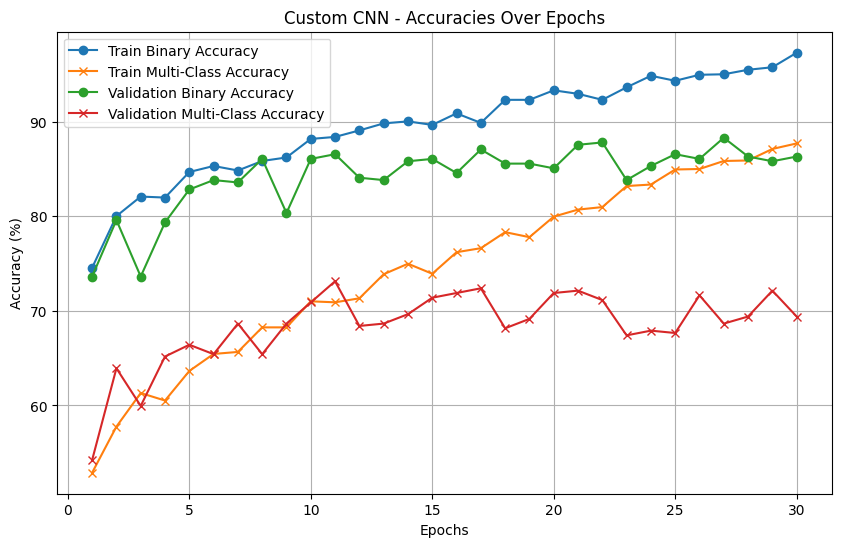

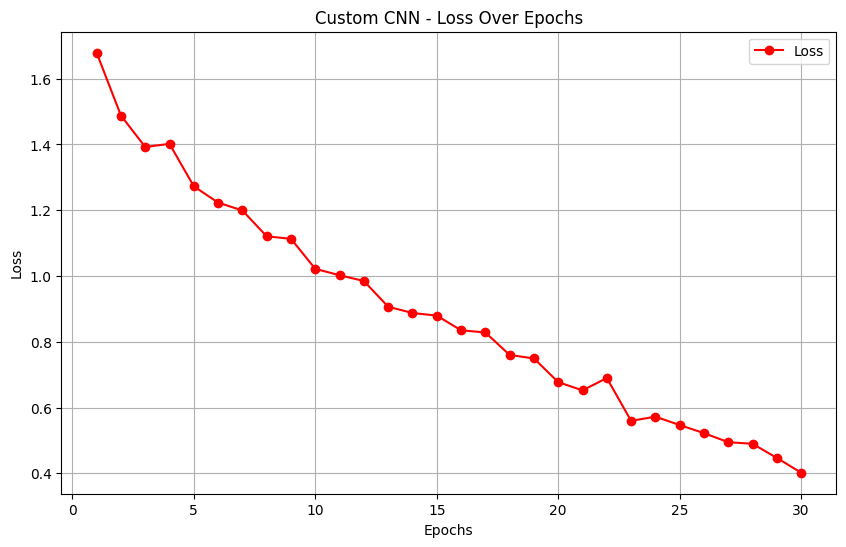

In [29]:
# Load the metrics data
metrics_data = pd.read_csv("training_metrics.csv")

# Plot accuracies
plot_accuracies(metrics_data, "Epochs", "Train Binary Accuracy", "Train Multi-Class Accuracy", "Validation Binary Accuracy", "Validation Multi-Class Accuracy")

# Plot loss
plot_loss(metrics_data, "Epochs", "Loss")
